In [1]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

2026-02-01 14:35:13.508547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769956513.820882      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769956513.911834      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769956514.894639      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769956514.894678      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769956514.894681      24 computation_placer.cc:177] computation placer alr

In [2]:
pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
audio_dir = '/kaggle/input/ai-forge-gdgsrmist/train/train'

audio_files = [
    os.path.join(audio_dir, f)
    for f in os.listdir(audio_dir)
    if f.endswith('.wav')
]

In [4]:
ipd.Audio(audio_files[0])

In [5]:
sample_r  = 22050
dur = 10
samples_per_track= sample_r*dur

n_mels = 128 
n_fft = 2048
hop_length = 512


In [6]:
def extract_mel_spectrogram(file_path):
    signal, sr = librosa.load(file_path,sr=sample_r,duration=dur,res_type='kaiser_fast')
    if len(signal) < samples_per_track:
        signal = np.pad(signal, (0, samples_per_track - len(signal)))
    else:
        signal = signal[:samples_per_track]

    mel_spec = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=n_fft,hop_length=hop_length,n_mels=n_mels)

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


In [7]:
df = pd.read_csv('/kaggle/input/ai-forge-gdgsrmist/train.csv')
l_map = dict(zip(df['file_id'],df['genre']))

In [8]:
from tqdm import tqdm
features = []
output = []

for i in tqdm(audio_files):
    mel = extract_mel_spectrogram(i)
    features.append(mel)

    filename = os.path.basename(i)
    output.append(l_map[filename])


100%|██████████| 6576/6576 [18:10<00:00,  6.03it/s]


In [9]:
x = np.array(features)
y = np.array(output)

In [10]:
x[:1]

array([[[-35.705452, -38.923897, -35.953537, ..., -28.154182,
         -29.635145, -28.622576],
        [-24.96938 , -29.53514 , -28.823893, ..., -16.063972,
         -16.388197, -17.063984],
        [-12.821379, -13.448394, -13.892689, ..., -21.997902,
         -21.800928, -19.402847],
        ...,
        [-57.38105 , -59.296608, -58.17166 , ..., -80.      ,
         -79.5064  , -69.854965],
        [-65.553085, -69.36741 , -69.46933 , ..., -80.      ,
         -80.      , -70.32864 ],
        [-68.316635, -74.072586, -80.      , ..., -80.      ,
         -80.      , -70.71033 ]]], dtype=float32)

In [11]:
y[:20]

array(['electronic', 'lofi', 'country', 'lofi', 'electronic', 'jazz',
       'classical', 'lofi', 'classical', 'electronic', 'heavymetal',
       'rap', 'lofi', 'lofi', 'country', 'jazz', 'electronic', 'rap',
       'rap', 'country'], dtype='<U10')

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_trans = le.fit_transform(y)

In [13]:
y_trans[:50]

array([2, 5, 1, 5, 2, 4, 0, 5, 0, 2, 3, 7, 5, 5, 1, 4, 2, 7, 7, 1, 4, 5,
       5, 1, 2, 0, 0, 3, 2, 4, 5, 4, 6, 2, 5, 1, 4, 4, 7, 2, 4, 4, 3, 2,
       5, 3, 0, 5, 3, 1])

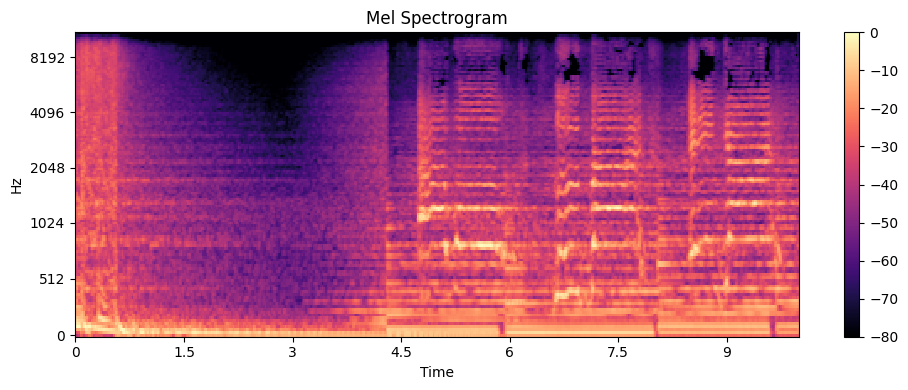

In [14]:
import librosa.display
import matplotlib.pyplot as plt

mel = extract_mel_spectrogram(audio_files[0])

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    mel,
    sr=sample_r,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar()
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()


# CNN



In [15]:
from sklearn.model_selection import train_test_split
x = x[..., np.newaxis]

x_train,x_val,y_train,y_val = train_test_split(x,y_trans,test_size = 0.2,random_state=42 )

In [16]:
x.shape

(6576, 128, 431, 1)

In [17]:
num_classes = len(np.unique(y_trans))
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1769957634.803683      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769957634.809819      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 429, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 429, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 212, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 212, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 104, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 104, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,112 (434.03 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/30


I0000 00:00:1769957642.679704      91 service.cc:152] XLA service 0x7f469404ec30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769957642.679750      91 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1769957642.679755      91 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1769957643.267303      91 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-01 14:54:05.952351: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 14:54:06.121467: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  2/165 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.0703 - loss: 2.4885 

I0000 00:00:1769957650.431520      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4360 - loss: 1.5920

2026-02-01 14:54:20.982342: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 14:54:21.144490: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 14:54:21.832212: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 14:54:22.123790: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.4368 - loss: 1.5897 - val_accuracy: 0.3830 - val_loss: 1.6320
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6068 - loss: 1.0963 - val_accuracy: 0.2850 - val_loss: 3.6495
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6743 - loss: 0.9266 - val_accuracy: 0.2006 - val_loss: 5.0953
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6983 - loss: 0.8458 - val_accuracy: 0.4696 - val_loss: 1.6276
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7192 - loss: 0.7560 - val_accuracy: 0.3693 - val_loss: 2.3830
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7269 - loss: 0.7429 - val_accuracy: 0.4947 - val_loss: 1.9637
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7479 - loss: 0.6865 - val_accuracy: 0.5699 - val_loss: 1.1979
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7565 - loss: 0.6490 - val_accura

In [20]:
print("Final train acc:", history.history["accuracy"][-1])
print("Final val acc:", history.history["val_accuracy"][-1])


Final train acc: 0.8330798745155334
Final val acc: 0.598024308681488


In [21]:
best_val_acc = max(history.history["val_accuracy"])
best_epoch = history.history["val_accuracy"].index(best_val_acc) + 1

print("Best val accuracy:", best_val_acc)
print("Best epoch:", best_epoch)


Best val accuracy: 0.7158054709434509
Best epoch: 11


In [22]:
model.save("mel_cnn_earlystop_best.keras")


# Accuracy Enhancement

In [23]:
import numpy as np

def spec_augment(mel, freq_mask=12, time_mask=20):
    mel = mel.copy()
    f = np.random.randint(0, freq_mask)
    f0 = np.random.randint(0, mel.shape[0] - f)
    mel[f0:f0+f, :] = 0
    
    t = np.random.randint(0, time_mask)
    t0 = np.random.randint(0, mel.shape[1] - t)
    mel[:, t0:t0+t] = 0

    return mel


In [24]:
x_train_aug = []
y_train_aug = []

for i in range(len(x_train)):
    x_train_aug.append(x_train[i])
    y_train_aug.append(y_train[i])

    aug = spec_augment(x_train[i].squeeze())
    x_train_aug.append(aug[..., np.newaxis])
    y_train_aug.append(y_train[i])

x_train_aug = np.array(x_train_aug)
y_train_aug = np.array(y_train_aug)


In [25]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    x_train_aug, y_train_aug,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/30
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7545 - loss: 0.6666

2026-02-01 14:57:29.470494: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 14:57:29.642884: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 14:57:30.719918: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 14:57:31.014550: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


329/329 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.7546 - loss: 0.6662 - val_accuracy: 0.7781 - val_loss: 0.5759
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.8128 - loss: 0.5042 - val_accuracy: 0.7903 - val_loss: 0.5530
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.8212 - loss: 0.4875 - val_accuracy: 0.7705 - val_loss: 0.6083
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8281 - loss: 0.4532 - val_accuracy: 0.7675 - val_loss: 0.6533
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8300 - loss: 0.4458 - val_accuracy: 0.8047 - val_loss: 0.5356
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8456 - loss: 0.4229 - val_accuracy: 0.8009 - val_loss: 0.5362
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8511 - loss: 0.3868 - val_accuracy: 0.8078 - val_loss: 0.5102
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8529 - loss: 0.3953 - val_accurac

In [27]:
best_val_acc = max(history.history["val_accuracy"])
print("Best val accuracy:", best_val_acc)

val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
print("Restored model val accuracy:", val_acc)

Best val accuracy: 0.8077507615089417
Restored model val accuracy: 0.8077507615089417


In [28]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)

print("Train acc:", train_acc)
print("Val accuracy:", val_acc)
print("Train loss:", train_loss)
print("Val loss:", val_loss)

Train acc: 0.8783270120620728
Val accuracy: 0.8077507615089417
Train loss: 0.32016506791114807
Val loss: 0.5102218389511108


In [29]:
model.save("mel_cnn_best.keras")


# Submission 


In [30]:
sub = pd.read_csv('/kaggle/input/ai-forge-gdgsrmist/sample_submission.csv')

In [31]:
sub.head()

,file_id,genre
0,test_pub_00001.wav,NaN
1,test_pub_00002.wav,NaN
2,test_pub_00003.wav,NaN
3,test_pub_00004.wav,NaN
4,test_pub_00005.wav,NaN


In [32]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("mel_cnn_best.keras")

test_features = []

for fname in sub["file_id"]:
    path = f"/kaggle/input/ai-forge-gdgsrmist/test/test/{fname}"
    mel = extract_mel_spectrogram(path)
    test_features.append(mel)

X_test = np.array(test_features)[..., np.newaxis]

preds = model.predict(X_test)
pred_labels = np.argmax(preds, axis=1)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


In [33]:
final_labels = le.inverse_transform(pred_labels)
submission = sub.copy()
submission["genre"] = final_labels

submission.head(10)


,file_id,genre
0,test_pub_00001.wav,jazz
1,test_pub_00002.wav,heavymetal
2,test_pub_00003.wav,country
3,test_pub_00004.wav,jazz
4,test_pub_00005.wav,classical
5,test_pub_00006.wav,classical
6,test_pub_00007.wav,heavymetal
7,test_pub_00008.wav,electronic
8,test_pub_00009.wav,jazz
9,test_pub_00010.wav,rap


In [34]:
submission.to_csv("submission.csv", index=False)